In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
3059,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o
3060,60108.325752,17.942,0.079,242.0,19.0,o,0,1.02,285.39033,14.93599,2955.37,4458.28,1.98,1.80,70.9,-0.421,18.88,20.32,04a60108o0827o
3061,60109.451577,18.911,0.522,99.0,52.0,c,0,1.21,285.39033,14.93599,2974.43,4421.28,3.03,2.91,35.9,-0.415,17.78,19.41,02a60109o0267c


In [5]:
oband = atlas[atlas['f']=='o']
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,60103.508484,17.797,0.074,276.0,20.0,o,0,0.98,285.39033,14.93599,8706.61,698.96,2.12,1.61,-63.1,-0.546,18.96,19.99,02a60103o0551o
3057,60108.303209,17.852,0.079,263.0,21.0,o,0,0.98,285.39033,14.93599,2999.14,4396.12,2.02,1.81,76.0,-0.430,18.97,20.53,04a60108o0778o
3058,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
3059,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o


In [6]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,60103.508484,17.797,0.074,276.0,20.0,o,0,0.98,285.39033,14.93599,8706.61,698.96,2.12,1.61,-63.1,-0.546,18.96,19.99,02a60103o0551o
2371,60108.303209,17.852,0.079,263.0,21.0,o,0,0.98,285.39033,14.93599,2999.14,4396.12,2.02,1.81,76.0,-0.430,18.97,20.53,04a60108o0778o
2372,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
2373,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o


In [7]:
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,60103.508484,17.797,0.074,276.0,20.0,o,0,0.98,285.39033,14.93599,8706.61,698.96,2.12,1.61,-63.1,-0.546,18.96,19.99,02a60103o0551o
2371,60108.303209,17.852,0.079,263.0,21.0,o,0,0.98,285.39033,14.93599,2999.14,4396.12,2.02,1.81,76.0,-0.430,18.97,20.53,04a60108o0778o
2372,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
2373,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o


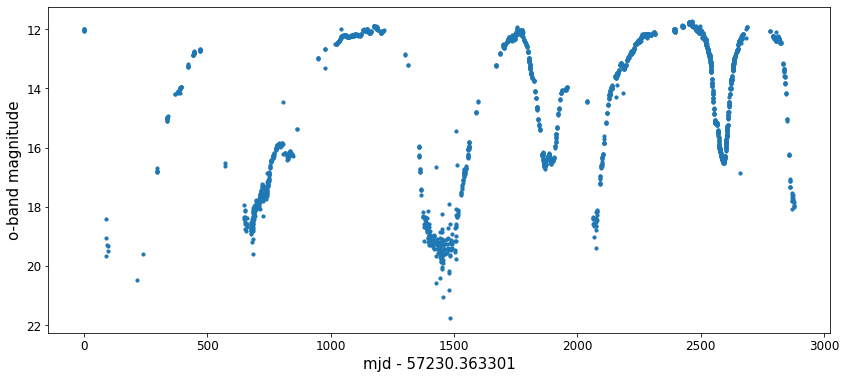

In [8]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [9]:
median_filtered = sp.signal.medfilt(oband['m'],kernel_size=5)

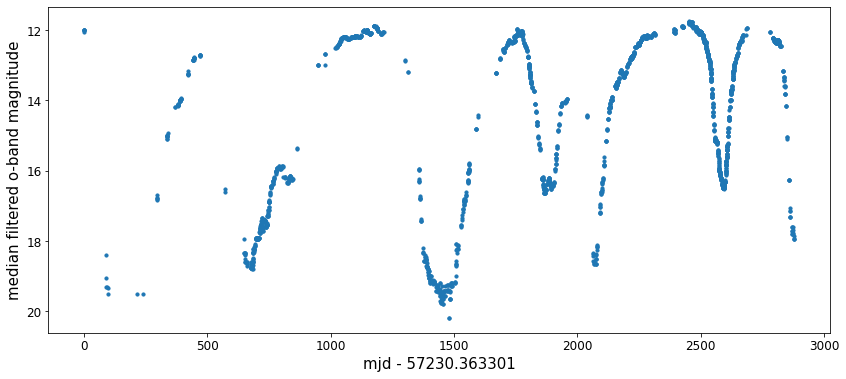

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
plt.show()

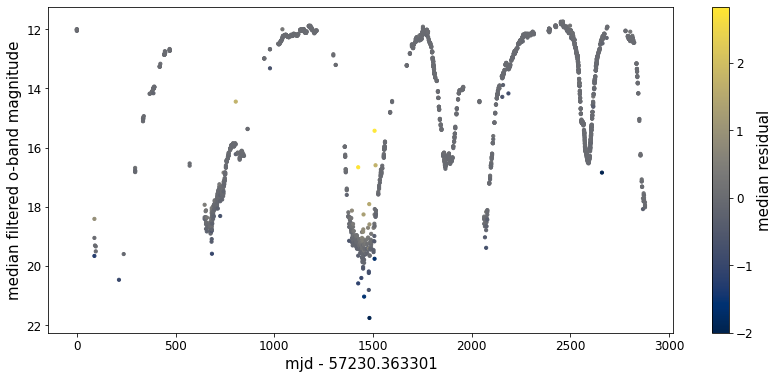

In [11]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=median_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='median residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

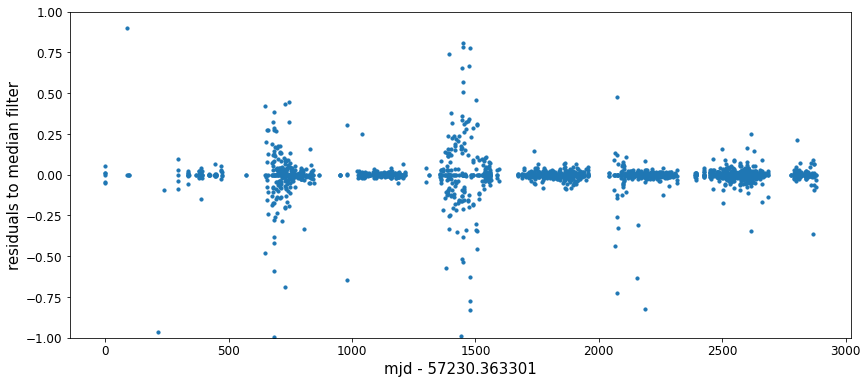

In [12]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered-oband['m'],s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to median filter')
plt.ylim(-1,1)
plt.show()

In [13]:
mask = np.where(np.abs(median_filtered-oband['m'])<0.25,True,False)
mask

array([ True,  True,  True, ...,  True,  True,  True])

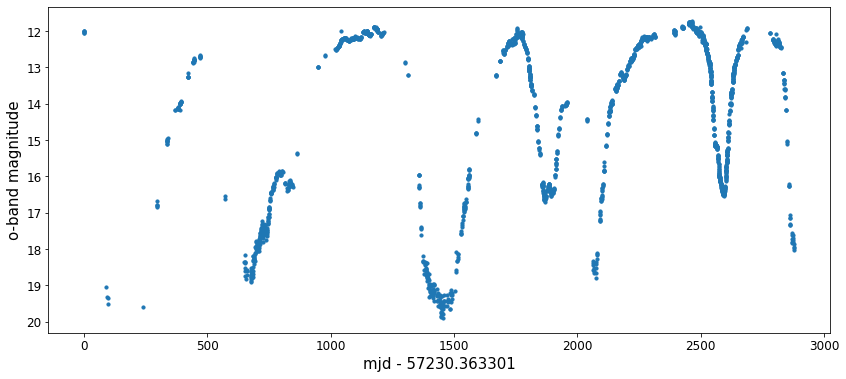

In [14]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd'][mask]-oband['mjd'][0],oband['m'][mask],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [15]:
median_filtered_oband = oband.iloc[mask]
median_filtered_oband.reset_index(drop=True,inplace=True)
median_filtered_oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57230.363301,12.044,0.002,55268.0,100.0,o,0,142.75,285.39033,14.93599,5243.16,529.14,3.79,3.60,-20.8,-0.510,18.66,19.83,02a57230o0153o
1,57230.364071,12.001,0.002,57498.0,98.0,o,0,144.51,285.39033,14.93599,7367.53,10265.03,3.88,3.63,-77.6,-0.471,18.70,19.91,02a57230o0154o
2,57230.392834,12.014,0.002,56832.0,99.0,o,0,214.81,285.39033,14.93599,3442.31,124.97,3.97,3.51,-26.0,-0.508,18.76,19.99,02a57230o0188o
3,57230.395061,12.054,0.002,54762.0,97.0,o,0,107.76,285.39033,14.93599,5564.60,9856.66,3.68,3.55,-62.0,-0.468,18.73,19.93,02a57230o0190o
4,57230.415453,12.005,0.002,57286.0,98.0,o,0,152.72,285.39033,14.93599,1974.56,1598.85,3.92,3.53,-45.6,-0.478,18.77,19.98,02a57230o0213o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284,60103.508484,17.797,0.074,276.0,20.0,o,0,0.98,285.39033,14.93599,8706.61,698.96,2.12,1.61,-63.1,-0.546,18.96,19.99,02a60103o0551o
2285,60108.303209,17.852,0.079,263.0,21.0,o,0,0.98,285.39033,14.93599,2999.14,4396.12,2.02,1.81,76.0,-0.430,18.97,20.53,04a60108o0778o
2286,60108.305950,17.976,0.059,234.0,14.0,o,0,2.49,285.39033,14.93599,3020.85,4432.94,1.94,1.77,74.8,-0.431,18.96,20.52,04a60108o0784o
2287,60108.310971,18.019,0.085,225.0,19.0,o,0,0.98,285.39033,14.93599,2966.31,4351.88,1.93,1.75,71.8,-0.428,18.95,20.46,04a60108o0795o


In [16]:
# edge_detect = sp.ndimage.convolve(oband['m'][mask], CustomKernel([1.0, 0.0, -1.0]))
edge_detect = sp.ndimage.convolve(median_filtered_oband['m'], [1.0, 0.0, -1.0])

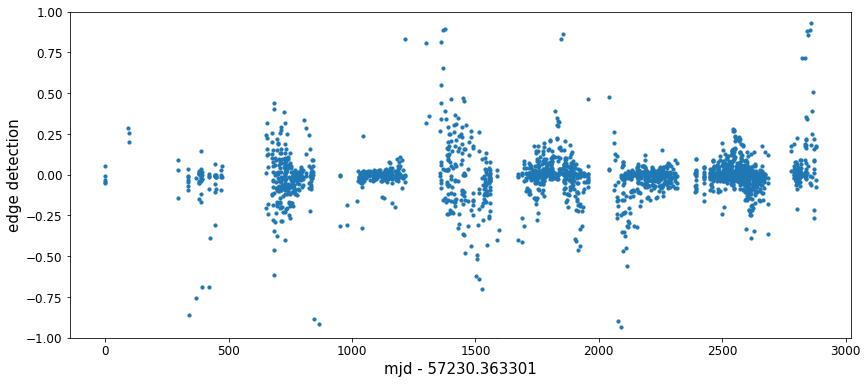

In [17]:
mjd_scale = median_filtered_oband['mjd'][0]

plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('edge detection')
plt.ylim(-1,1)
plt.show()

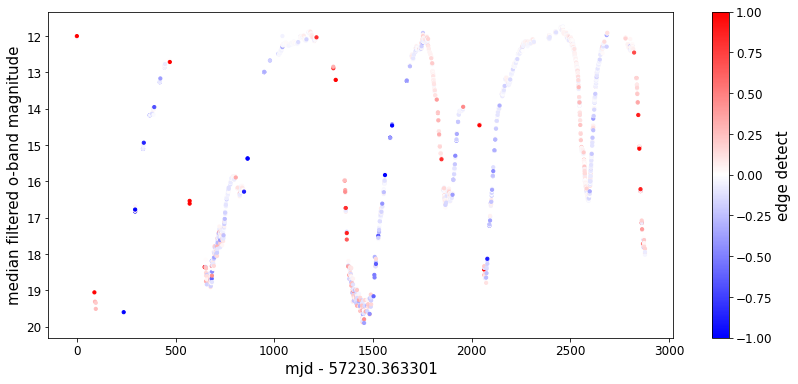

In [18]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
            c=edge_detect,cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-1,1)
plt.show()

In [19]:
interpolation_function = sp.interpolate.interp1d(np.asarray(median_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(median_filtered_oband['m']),
                                                 kind='slinear')
## what time resolution? I don't want to lose any of the real data if possible
real_resolution = np.median(np.diff(median_filtered_oband['mjd']))
len_data = np.max(median_filtered_oband['mjd']-mjd_scale)
resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
resample_flux = interpolation_function(resample_time)

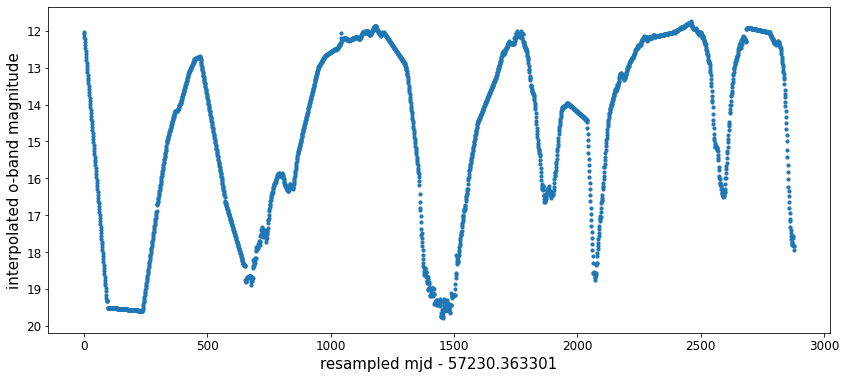

In [20]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.show()

In [21]:
new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

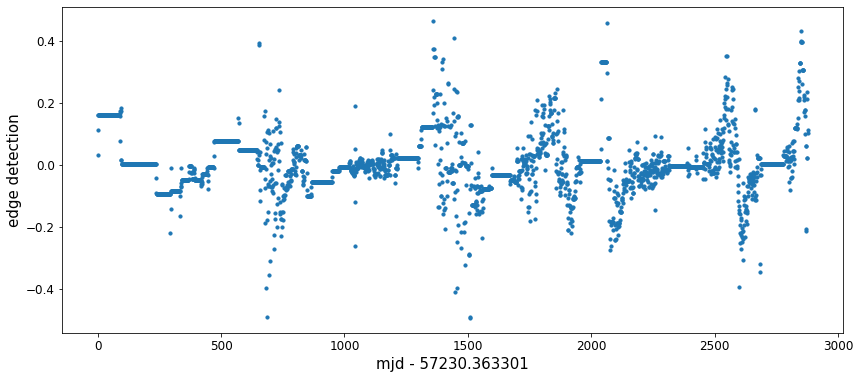

In [22]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,new_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
# plt.ylim(-1,1)
plt.show()

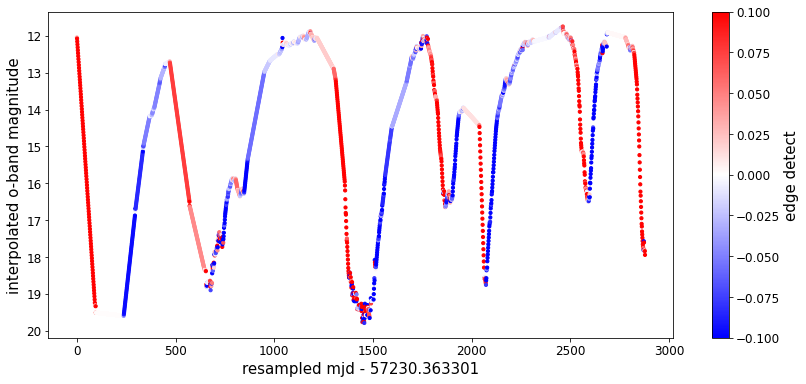

In [23]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

In [24]:
## interpolate the edge detection to convert back to the original times
edge_detect_interp_func = sp.interpolate.interp1d(resample_time,
                                                 new_edge_detect,
                                                 kind='slinear')

edges_realdata = edge_detect_interp_func(median_filtered_oband['mjd']-mjd_scale)


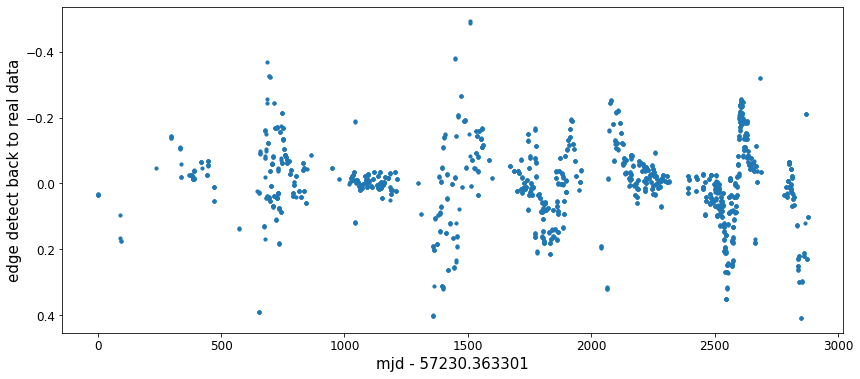

In [25]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,edges_realdata,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('edge detect back to real data')
# plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
# plt.clim(-1,1)
plt.show()

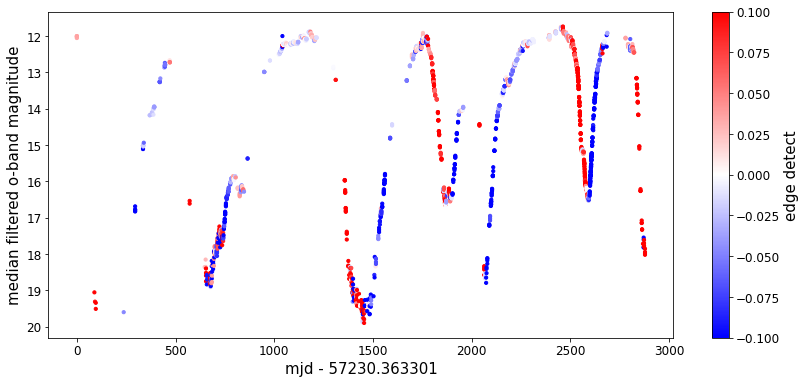

In [26]:
plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
            c=(edges_realdata),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

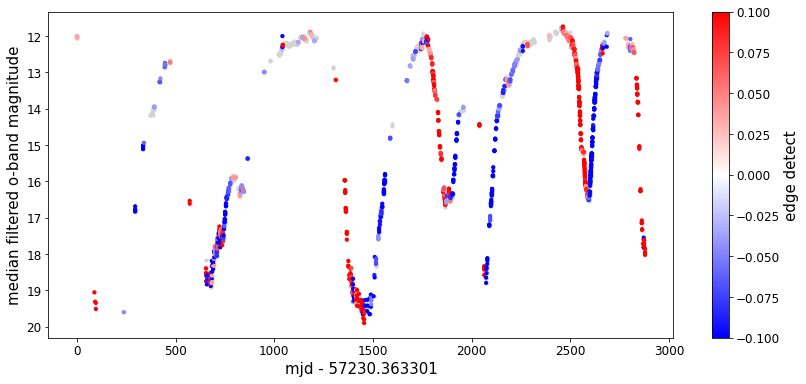

In [27]:
std_dev = np.std(edges_realdata)
# std_dev
new_mask = np.where(np.abs(edges_realdata)>(std_dev*0.25),True,False)

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][new_mask]-mjd_scale,median_filtered_oband['m'][new_mask],s=10,
            c=(edges_realdata[new_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

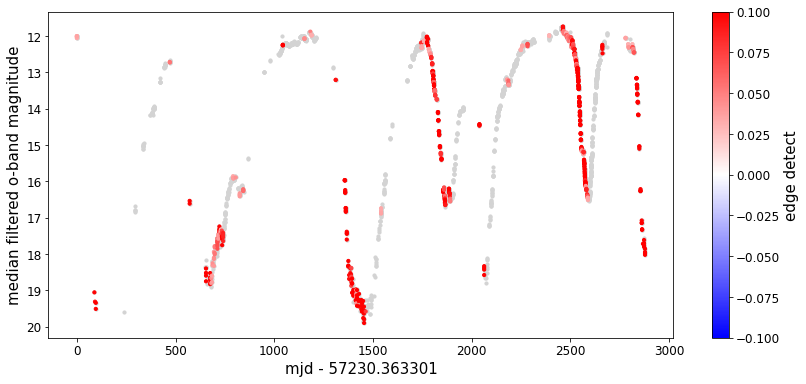

In [28]:
std_dev = np.std(edges_realdata)
new_mask = np.where(np.abs(edges_realdata)>(std_dev*0.25),True,False)
downslope_mask = np.where(edges_realdata>0.0,True,False)
total_mask = new_mask & downslope_mask

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(edges_realdata[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [29]:
print(median_filtered_oband['mjd'][total_mask]-mjd_scale)

0          0.000000
1          0.000770
2          0.029533
3          0.031760
4          0.052152
           ...     
2284    2873.145183
2285    2877.939908
2286    2877.942649
2287    2877.947670
2288    2877.962451
Name: mjd, Length: 763, dtype: float64


In [30]:
def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [31]:
run_vals, run_start, run_length = find_runs(total_mask)

In [32]:
downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [33]:
median_filtered_oband['mjd'][downward_mask]-mjd_scale

0          0.000000
76       470.858114
85       654.123333
93       675.093549
123      694.143158
131      698.127956
157      712.103244
167      716.098459
175      722.070265
184      728.066794
194      730.063550
204      734.045506
220      741.026196
283      790.924633
306      824.832157
326      842.888975
363     1043.205120
486     1152.945955
528     1188.832479
550     1311.289435
578     1385.204800
590     1390.154873
605     1401.113653
614     1413.124099
626     1419.100841
638     1441.059998
656     1454.072856
711     1540.957008
822     1745.133735
851     1759.133591
869     1773.107158
889     1779.181547
1007    1859.989085
1056    1884.965488
1064    1888.890598
1141    2039.252763
1283    2179.054072
1295    2186.058780
1398    2248.893480
1417    2256.944638
1457    2282.879673
1539    2462.163763
1560    2480.129367
1581    2487.126565
1606    2502.106377
1630    2510.085934
1646    2514.048427
1667    2520.088596
1717    2536.028425
1824    2565.059336


In [34]:
median_filtered_oband['mjd'][run_start]

0       57230.363301
10      57467.632340
76      57701.221415
81      57877.609496
85      57884.486634
            ...     
2164    60022.614377
2171    60029.385564
2222    60044.374858
2277    60101.482779
2281    60103.476541
Name: mjd, Length: 127, dtype: float64

In [35]:
median_filtered_oband['m'][run_start]

0       12.044
10      19.598
76      12.728
81      18.356
85      18.395
         ...  
2164    12.223
2171    12.343
2222    12.270
2277    17.820
2281    17.612
Name: m, Length: 127, dtype: float64

In [36]:
decline_onset = []
decline_end = []
for i in range(0,len(median_filtered_oband['m'][run_start])-1):
    if median_filtered_oband['m'][run_start[i+1]] - median_filtered_oband['m'][run_start[i]] > 0.8:#1:
        decline_onset.append(run_start[i])
        print(run_start[i])
        print(median_filtered_oband['mjd'][run_start[i]])
        print(median_filtered_oband['m'][run_start[i+1]] - median_filtered_oband['m'][run_start[i]])

0
57230.363301
7.5539999999999985
76
57701.221415
5.628000000000002
532
58423.194901
1.1659999999999986
550
58541.652736
5.208000000000002
889
59009.544848
4.163
1141
59269.616064
4.164
1717
59766.391726
2.2630000000000017
1824
59795.422637
1.149000000000001
2222
60044.374858
5.550000000000001


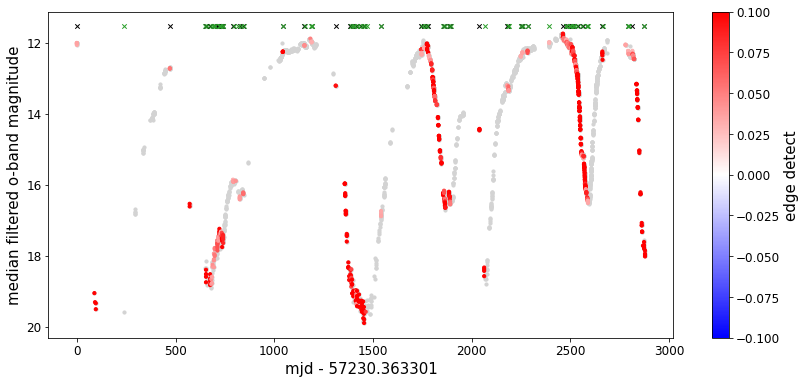

In [37]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][downward_mask]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][downward_mask]),np.min(median_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][upward_mask]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][upward_mask]),np.min(median_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(median_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][decline_onset]),np.min(median_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(edges_realdata[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
plt.show()

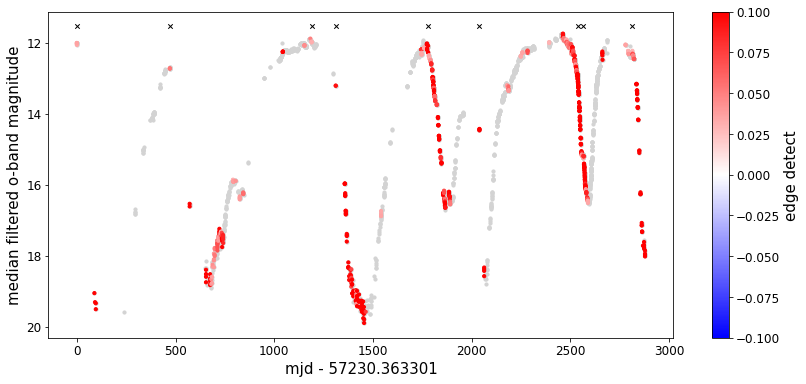

In [38]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(median_filtered_oband['mjd'][downward_mask]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][downward_mask]),np.min(median_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(median_filtered_oband['mjd'][upward_mask]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][upward_mask]),np.min(median_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
plt.scatter(median_filtered_oband['mjd'][decline_onset]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][decline_onset]),np.min(median_filtered_oband['m']))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(edges_realdata[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()